<a href="https://colab.research.google.com/github/nickteim/typedef/blob/mashine_learning/closer_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/alinstein/Depth_estimation

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!git clone https://github.com/alinstein/Depth_estimation.git

Cloning into 'Depth_estimation'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 132 (delta 34), reused 74 (delta 16), pack-reused 40
Receiving objects: 100% (132/132), 140.28 MiB | 35.79 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [ ]:
PATH = '/content/drive/My Drive/kaggle/Mobilenet/6.pth'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        #interpolate x from x.size to larger size(concat_with.shape=(C,H,W))
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.leakyreluA(self.convA( torch.cat([up_x, concat_with], dim=1) ) ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=2208, decoder_width = 0.25):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=1)

        self.up1 = UpSample(skip_input=features//1 + 384, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 192, output_features=features//4)
#         self.up3 = UpSample(skip_input=features//4 +  96, output_features=features//8)
        self.up3 = UpSample(skip_input=features//4 +  96, output_features=features//16)
        self.up4 = UpSample(skip_input=features//8 +  96, output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[11]
        x_d0 = self.conv2(x_block4)
        #15x20 to 15x20
        x_d1 = self.up1(x_d0, x_block3)
        #15x20 to 30x40
        x_d2 = self.up2(x_d1, x_block2)
        #30x40 to 60x80
        x_d3 = self.up3(x_d2, x_block1)
        #60x80 to 120x160
#         x_d4 = self.up4(x_d3, x_block0)
        #120x160 to 240x320
        return self.conv3(x_d3)
       # return self.conv3(x_d4)

#Encoder uses the densenet_161 pretrained model
#following encoder encodes the image and store the features output from each output of layer
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        import torchvision.models as models
        self.original_model = models.densenet161( pretrained=True )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )

In [ ]:
model = TheModelClass()
model.load_state_dict(torch.load(PATH),strict=False)
model.eval()

TheModelClass(
  (encoder): Encoder(
    (original_model): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _Den

In [ ]:
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
import torchvision.models as models
import cv2

In [ ]:
img = '/content/street2.PNG'

# Upload video

In [1]:
!pip install pytube3

In [2]:
from pytube import YouTube
from moviepy.editor import *
 
# download a file from youtube
youtube_link = 'https://www.youtube.com/watch?v=E1VAsO_lkrw'
w = YouTube(youtube_link).streams.first()
w.download(output_path="/content/")

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)696320/45929032 bytes (1.5%)1990656/45929032 bytes (4.3%)3809280/45929032 bytes (8.3%)6373376/45929032 bytes (13.9%)9895936/45929032 bytes (21.5%)13541376/45929032 bytes (29.5%)17285120/45929032 bytes (37.6%)20856832/45929032 bytes (45.4%)24641536/45929032 bytes (53.7%)27975680/45929032 bytes (60.9%)31473664/45929032 bytes (68.5%)35094528/45929032 bytes (76.4%)38641664/

'/content/London Street Slow Motion.mp4'

# Video

In [3]:
!cat '/content/drive/My Drive/kaggle/Depth_estimation/UtilityTest.py'

import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

def _is_pil_image(img):
    return isinstance(img, Image.Image)

def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})

class DepthDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir,os.listdir(self.root_dir)[idx])
        image = (Image.open(img_name))

        sample1={'image': image}

        if self.transform:  sample1 = self.transform({'image': image})
        return sample1
    
    

class ToTensor(object):
    def __init__(self,is_test=False):
        self.is_test

In [4]:
!cat '/content/drive/My Drive/kaggle/Depth_estimation/Mobile_model.py'

import torch
import torch.nn as nn
import torch.nn.functional as F

class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.leakyreluA(self.convA( torch.cat([up_x, concat_with], dim=1) ) ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=1280, decoder_width = .6):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features

In [5]:
import sys
sys.path.append('/content/drive/My Drive/kaggle/Depth_estimation')

In [6]:
import cv2
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import imageio
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from UtilityTest import DepthDataset
from UtilityTest import ToTensor

In [26]:
Location_video='/content/London Street Slow Motion.mp4'

In [35]:
# import shutil
# shutil.rmtree('/content/test_vid')

In [ ]:
# for root, dirs, files in os.walk('/content/test_vid/Frames'):
#     for i,f in enumerate(files):
#         absname = os.path.join(root, f)
#         newname = os.path.join(root, 'bear'+'_'+str(i))
#         os.rename(absname, newname)

In [ ]:
# import cv2
# import os
# os.mkdir('/content/test_vid/')
# os.mkdir('/content/test_vid/Frames/')

# count=1
# vidcap = cv2.VideoCapture(Location_video)
# def getFrame(sec):
#     vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
#     hasFrames,image = vidcap.read()
#     if hasFrames:
#         cv2.imwrite("/content/test_vid/Frames/%d.jpg" % count, image) # Save frame as JPG file
#         hasFrames,image = vidcap.read()
#     return hasFrames, image
# sec = 0
# frameRate = 0.5 # Change this number to 1 for each 1 second

# success = getFrame(sec)
# while success:
#     count = count + 1
#     sec = sec + frameRate
#     sec = round(sec, 2)
#     success, image = getFrame(sec)
#     print('Read a new frame: ', success)

In [ ]:
# rename 's/\d+/sprintf("%02d", $&)/e'

In [44]:
# os.mkdir('/content/test_vid/')
# os.mkdir('/content/test_vid/Frames/')
# #converting video into frames
vidcap = cv2.VideoCapture(Location_video)
success,image = vidcap.read()
count = 7
# for i in range(1):
if success == True:
  cv2.imwrite("/content/test_vid/Frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1
  # i += 1

TypeError: ignored

In [16]:
# os.mkdir('/content/test_vid/')
# os.mkdir('/content/test_vid/Frames/')
#converting video into frames
# vidcap = cv2.VideoCapture(Location_video)
# success,image = vidcap.read()
# count = 0
# while success:
#   cv2.imwrite("/content/test_vid/Frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
#   success,image = vidcap.read()
#   print('Read a new frame: ', success)
#   count += 1

In [ ]:
# import shutil
# import os

# sourcedir = "/content/test_vid/Frames"; extensions = (".jpg", ".jpeg")
# files = [(f, f[f.rfind("."):], f[:f.rfind(".")]) for f in os.listdir(sourcedir)if f.endswith(extensions)]
# maxlen = len(max([f[2] for f in files], key = len))

# for item in files:
#     zeros = maxlen-len(item[2])
#     shutil.move(sourcedir+"/"+item[0], sourcedir+"/"+str(zeros*"0")+item[0])

In [ ]:
# import shutil
# import os

# sourcedir = "/content/test_vid/Frames"; number_ofdigits = 5; extensions = (".jpg", ".jpeg")

# files = os.listdir(sourcedir)
# for item in files:
#     if item.endswith(extensions):
#         name = item.split("."); zeros = number_ofdigits-len(name[0])
#         newname = str(zeros*"0")+name[0]+"."+name[1]
#         shutil.move(sourcedir+"/"+item, sourcedir+"/"+newname)

In [ ]:
# import os
# path = '/content/test_vid/Frames'
# for filename in os.listdir(path):
#     prefix, num = filename[:-4].split('_')
#     num = num.zfill(4)
#     new_filename = prefix + "_" + num + ".png"
#     os.rename(os.path.join(path, filename), os.path.join(path, new_filename))

In [ ]:
# Tcl().call('lsort', '-dict', path)

In [ ]:
# import shutil 
# shutil.rmtree('/content/test_vid/depth_frames')

0 (640, 480)
1 (640, 480)
2 (640, 480)


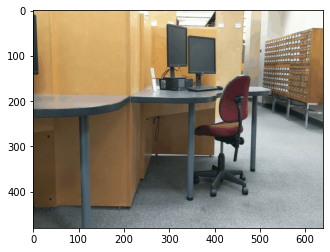

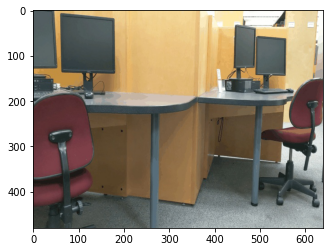

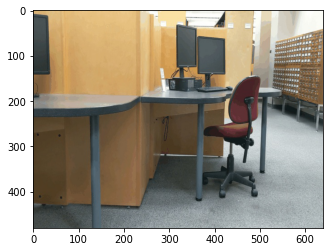

<Figure size 432x288 with 0 Axes>

In [ ]:
#location of video frames
loc_img='/content/test_vid/Frames/'

#ploting few sample frames
depth_dataset = DepthDataset(root_dir=loc_img)
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]

    print(i, sample['image'].size)


    plt.imshow(sample['image'])
    plt.figure()


    if i == 2:
        plt.show()
        break

In [ ]:

depth_dataset = DepthDataset(root_dir=loc_img,transform=transforms.Compose([ToTensor()]))

# depth_dataset
batch_size=1
train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size)
# train_loader
dataiter = iter(train_loader)


images = dataiter.next()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
import torchvision.models as models
from Mobile_model import Model
model = Model().cuda()
model = nn.DataParallel(model)
#loading the the trained model
model.load_state_dict(torch.load('/content/drive/My Drive/Kopi af 6.pth'))
model.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


DataParallel(
  (module): Model(
    (encoder): Encoder(
      (original_model): MobileNetV2(
        (features): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): InvertedResidual(
            (conv): Sequential(
              (0): ConvBNReLU(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU6(inplace=True)
              )
              (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (2): InvertedResidual(
    

In [ ]:
# os.mkdir('/content/test_vid/depth_frames/')

#generating the depth image of frames

import matplotlib.cm as cm
for i,sample_batched1  in enumerate (train_loader):
    image1 = sample_batched1['image']
    outtt=model(image1 )
    x=outtt.detach().cpu().numpy()
    x.shape
    x=x.reshape(240,320)
    img=x
    scale_percent = 200 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    plt.imsave('/content/test_vid/depth_frames/geeks%d.jpg' %i, resized, cmap='inferno')

In [ ]:
# from tkinter import *

In [ ]:
import shutil
import os

sourcedir = "/content/test_vid/depth_frames"; number_ofdigits = 5; extensions = (".jpg", ".jpeg")

files = os.listdir(sourcedir)
for item in files:
    if item.endswith(extensions):
        name = item.split("."); zeros = number_ofdigits-len(name[0])
        newname = str(zeros*"0")+name[0]+"."+name[1]
        shutil.move(sourcedir+"/"+item, sourcedir+"/"+newname)

In [ ]:
from os.path import isfile, join
 
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
    #for sorting the file names properly
    files.sort(key = lambda x: int(x[5:-4]))
    
    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'MP4V'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

In [ ]:
pathIn= '/content/test_vid/depth_frames/'
pathOut = '/content/test_vid/video1.mp4'
#enter the correct frame rates
fps = 3
convert_frames_to_video(pathIn, pathOut, fps)

/content/test_vid/depth_frames/geeks0.jpg
/content/test_vid/depth_frames/geeks1.jpg
/content/test_vid/depth_frames/geeks2.jpg
/content/test_vid/depth_frames/geeks3.jpg
/content/test_vid/depth_frames/geeks4.jpg
/content/test_vid/depth_frames/geeks5.jpg
/content/test_vid/depth_frames/geeks6.jpg
/content/test_vid/depth_frames/geeks7.jpg
/content/test_vid/depth_frames/geeks8.jpg
/content/test_vid/depth_frames/geeks9.jpg
/content/test_vid/depth_frames/geeks10.jpg
/content/test_vid/depth_frames/geeks11.jpg
/content/test_vid/depth_frames/geeks12.jpg
/content/test_vid/depth_frames/geeks13.jpg
/content/test_vid/depth_frames/geeks14.jpg
/content/test_vid/depth_frames/geeks15.jpg
/content/test_vid/depth_frames/geeks16.jpg
/content/test_vid/depth_frames/geeks17.jpg
/content/test_vid/depth_frames/geeks18.jpg
/content/test_vid/depth_frames/geeks19.jpg
/content/test_vid/depth_frames/geeks20.jpg
/content/test_vid/depth_frames/geeks21.jpg
/content/test_vid/depth_frames/geeks22.jpg
/content/test_vid/dep

In [ ]:
assert False

# convert to gif

In [ ]:

#converting the frames to gif

filenames='/content/test_vid/depth_frames/'
files = [f for f in os.listdir(filenames) if isfile(join(filenames, f))]

files.sort(key = lambda x: int(float(x[5:-4])))
files
images = []
for i,filename in enumerate(files):
    if i%10==0:
        images.append(imageio.imread(os.path.join('/content/test_vid/depth_frames/',filename)))
        print(filename)
imageio.mimsave('/content/test_vid/movie_depth.gif', images)

In [ ]:

from skimage import transform,io
filenames='/content/test_vid/Frames/'
files = [f for f in os.listdir(filenames) if isfile(join(filenames, f))]

files.sort(key = lambda x: int(float(x[5:-4])))
files
images = []
for i,filename in enumerate(files):
    if i%10==0:
       

            # resize to 28x28
        grey=(imageio.imread(os.path.join('/content/test_vid/Frames/',filename)))
        image = transform.resize(grey, (480,640), mode='symmetric', preserve_range=True)
        images.append(image)
        print(filename)
imageio.mimsave('/content/test_vid/movie_real.gif', images)